In [2]:
import pandas as pd
import kaggle 
import zipfile
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Read Data

In [3]:
# zipName = 'nfl-big-data-bowl-2024.zip'
# with zipfile.ZipFile(zipName, 'r') as file:
#     file.extractall()

In [4]:
games = pd.read_csv('games.csv')
players = pd.read_csv('players.csv')
tackles = pd.read_csv('tackles.csv')

## Clean tackle data

In [5]:
tackles = tackles.sort_values(['gameId', 'nflId'])
mapper = {}

def swapIdPlayer(id: int) -> str:
    name = players[players['nflId'] == id].values[0][6]
    return name

In [32]:
# tackles.head()

In [7]:
all_ids = players.nflId.unique()
nameAndPosition_map = {}
#Map id's to the player name
for i in range(len(all_ids)):
    nameAndPosition_map[all_ids[i]] = (players.loc[players['nflId'] == all_ids[i]].displayName[i] , players.loc[players['nflId'] == all_ids[i]].position[i])
    
# add nflID, player name, and position
tackles['tackler'] = tackles['nflId'].map(nameAndPosition_map)
tackles['pos'] = tackles['tackler'].str[1]
tackles['tackler'] = tackles['tackler'].str[0]
tackles = tackles[['gameId', 'playId', 'nflId', 'tackler', 'pos', 'tackle', 'assist', 'forcedFumble', 'pff_missedTackle']]

In [8]:
# Remove game id and play id
overall_tackle_statistics = tackles[tackles.columns[[2,3,4,5,6,7,8]]]
overall_tackle_statistics = overall_tackle_statistics.groupby(['tackler'], as_index = False).aggregate({'nflId':'first', 'pos': 'first', 'tackle': 'sum', 'assist': 'sum', 'forcedFumble': 'sum', 'pff_missedTackle': 'sum'})
overall_tackle_statistics['total_tackles'] = overall_tackle_statistics['tackle'] + overall_tackle_statistics['assist']
overall_tackle_statistics.sort_values('total_tackles', ascending= False)

,tackler,nflId,pos,tackle,assist,forcedFumble,pff_missedTackle,total_tackles
106,C.J. Mosley,41243,ILB,55,32,0,8,87
291,Foyesade Oluokun,46269,ILB,59,26,0,11,85
422,Jordyn Brooks,52435,ILB,61,23,1,10,84
655,Rashaan Evans,46091,ILB,45,39,1,6,84
795,Zaire Franklin,46304,OLB,55,28,0,12,83
...,...,...,...,...,...,...,...,...
277,Eric Johnson,54624,DT,0,0,0,1,0
273,Elijah Lee,45045,OLB,0,0,0,1,0
468,Keir Thomas,54750,OLB,0,0,0,1,0
226,Demetrius Taylor,55030,DT,0,0,0,1,0


## Breakdown of each position and the distribution of total tackle (Solo + Assist) numbers

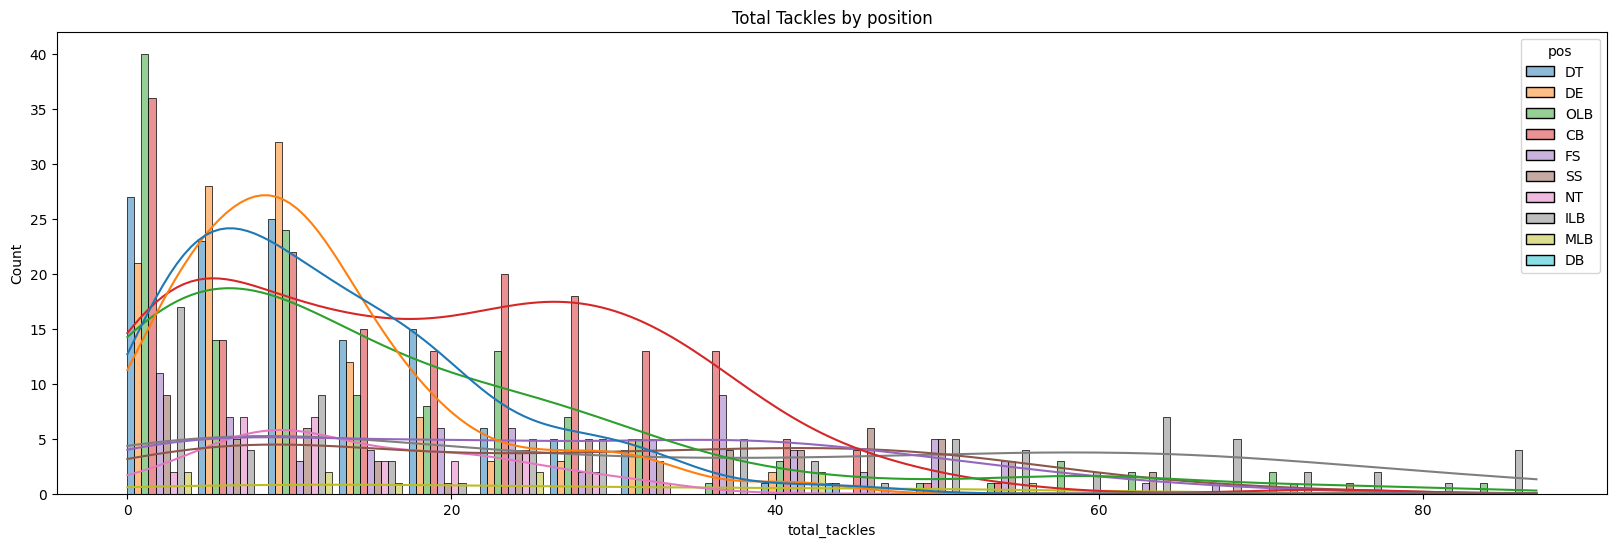

In [9]:
overall_tackle_statistics['total_tackles'] = overall_tackle_statistics['tackle'] + overall_tackle_statistics['assist']
overall_tackle_statistics.head()
plt.figure(figsize=(20, 6))
vis_1 = sns.histplot(data = overall_tackle_statistics, 
                     x = overall_tackle_statistics['total_tackles'], 
                     hue = 'pos', 
                     multiple = 'dodge',
                     bins = 20,
                     kde= True
                     ).set(
                         title = 'Total Tackles by position'
                     )
plt.show()


### Relationship between total tackles : missed tackles by position

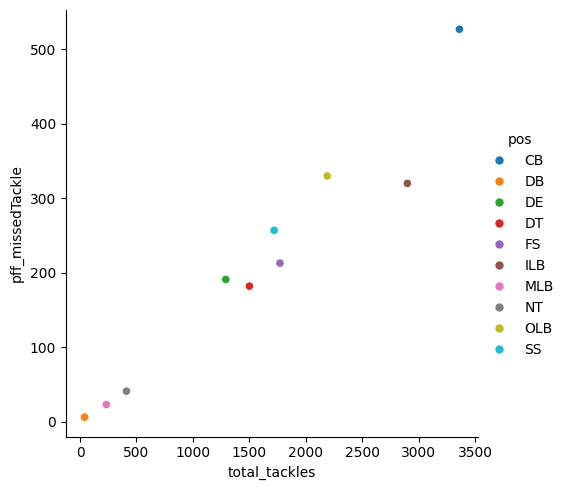

In [10]:
position_tackles = overall_tackle_statistics.drop(['tackler'], axis = 1).groupby('pos').aggregate({'pos': 'first', 'tackle': 'sum', 'assist': 'sum', 'forcedFumble': 'sum', 'pff_missedTackle': 'sum', 'total_tackles': 'sum'})
vis_2 = sns.relplot(kind = 'scatter', x = 'total_tackles', y = 'pff_missedTackle', data = position_tackles, hue = 'pos')

# play-by-play analysis

In [11]:
plays = pd.read_csv('plays.csv')
droppable = ['preSnapHomeScore', 
             'preSnapVisitorScore', 
             'preSnapHomeTeamWinProbability', 
             'preSnapVisitorTeamWinProbability',
             'homeTeamWinProbabilityAdded',
             'visitorTeamWinProbilityAdded']
plays = plays.drop(droppable, axis = 1)

### First thing we need to do is remove all plays that resulted in a touchdown as no tackle is being made

In [12]:
length_plays = plays.shape[0]
touchdown_plays = np.array([])
for i in range(length_plays):
    if (plays.iloc[i].playDescription.find('TOUCHDOWN') >= 1):
        touchdown_plays = np.append(touchdown_plays , i)
touchdown_plays
plays = plays.drop(touchdown_plays, axis = 0)
plays.reset_index(drop=True, inplace=True)

In [13]:
# print(plays.loc[[18]])

### What is considered efficient tackling?

##### As per PFF, efficient tackling is when the ration between total attempted tackles and missed tackles is relatively high, meaning players are attempting a lot of tackles and not mising too many.

##### The equation used here for tackling efficiency = (Tackles + Assists + Missed Tackles) / Missed Tackles

In [14]:
#Add tackler efficiency to the overall_tackle_statistics table
overall_tackle_statistics['tackler_efficiency'] = (overall_tackle_statistics['total_tackles'] + overall_tackle_statistics['pff_missedTackle']) / overall_tackle_statistics['pff_missedTackle']

#Players with over twenty tackles
# twenty_tackles = overall_tackle_statistics[overall_tackle_statistics.total_tackles >= 20]

overall_tackle_statistics

,tackler,nflId,pos,tackle,assist,forcedFumble,pff_missedTackle,total_tackles,tackler_efficiency
0,A'Shawn Robinson,43335,DT,16,18,0,3,34,12.333333
1,A.J. Epenesa,52462,DE,1,1,0,5,2,1.400000
2,A.J. Klein,40096,OLB,3,1,0,2,4,3.000000
3,A.J. Parker,53957,CB,10,2,0,0,12,inf
4,A.J. Terrell,52424,CB,19,9,0,8,28,4.500000
...,...,...,...,...,...,...,...,...,...
794,Zack Baun,52482,OLB,1,1,0,1,2,3.000000
795,Zaire Franklin,46304,OLB,55,28,0,12,83,7.916667
796,Zaven Collins,53445,OLB,39,24,1,13,63,5.846154
797,Zech McPhearson,53552,CB,2,0,0,0,2,inf


##### The issue I am are seeing now is that there are some players who just haven't had a missed tackle, which is usually due to them not attempting too many. The next step here would be to figure out how many total snaps players have played, and add their tackle attempt : snaps ratio which will help me filter out players who don't play too many snaps, and players who don't tackle very well.

In [15]:
"""
Figuring out how many snaps each player played is the hard part, since that's not readily available. Current leading way I am thinking of 
doing this is by using the tracking data per week. and counting every unique occurence of a player, and play. For example, Aaron Donald
lets say in the table we first see him in play #1. He will be listed 5-10 times within that one play, however we only want to count him once
for that play. Therefore, we need to figure out a way to look at both the unique play ID's and unique players within the play ID.

Lets say we loop through the tracking_data. If we see Aaron donald we look him up in the players table increment snap_count which we need to make
and save the last play we see him so for example play #1. Then when we see him again, in lets say play #5, we increment snap_count again, and replace
the play with play #5. However if we see him again in play #1, we don't increment snap_count again.

"""
#Method 1: go through every line of file, lookup play number and player and increment snapcount when playId is not equal to previous playId.

# week1_tracking = pd.read_csv('tracking_week_1.csv')

# overall_tackle_statistics['snap_count'] = 0
# overall_tackle_statistics['last_play'] = 0

# week1_length = week1_tracking.shape[0]
# for i in range(week1_length):
#     player_name = week1_tracking.iloc[i].displayName
#     playId = week1_tracking.iloc[i].playId
#     if player_name in overall_tackle_statistics['tackler'].values:
#         if playId == overall_tackle_statistics.loc[overall_tackle_statistics['tackler'] == player_name].last_play.item():
#             continue
#         else:
#             overall_tackle_statistics.loc[overall_tackle_statistics['tackler'] == player_name, ['last_play']] = playId
#             overall_tackle_statistics.loc[overall_tackle_statistics['tackler'] == player_name, ['snap_count']] += 1
#     else:
#         continue

# overall_tackle_statistics
# overall_tackle_statistics = overall_tackle_statistics.drop(['last_play'], axis = 1)

#Method 2: Preload data, filter to only rows where frameId = 1, then go through each row and add to snap count RUNTIME == 12 seconds
# overall_tackle_statistics['snap_count'] = 0

# week1_tracking = pd.read_csv('tracking_week_1.csv')
# week1_tracking = week1_tracking.loc[week1_tracking['frameId'] == 1]    
# for i in range(week1_tracking.shape[0]):
#     player_name = week1_tracking.iloc[i].displayName
#     id_num = week1_tracking.iloc[i].nflId
#     if player_name in overall_tackle_statistics['tackler'].values:
#         if id_num == overall_tackle_statistics.loc[overall_tackle_statistics['tackler'] == player_name, ['nflId']].values[0][0]:
#             overall_tackle_statistics.loc[overall_tackle_statistics['tackler'] == player_name, ['snap_count']] += 1

# overall_tackle_statistics

"\nFiguring out how many snaps each player played is the hard part, since that's not readily available. Current leading way I am thinking of \ndoing this is by using the tracking data per week. and counting every unique occurence of a player, and play. For example, Aaron Donald\nlets say in the table we first see him in play #1. He will be listed 5-10 times within that one play, however we only want to count him once\nfor that play. Therefore, we need to figure out a way to look at both the unique play ID's and unique players within the play ID.\n\nLets say we loop through the tracking_data. If we see Aaron donald we look him up in the players table increment snap_count which we need to make\nand save the last play we see him so for example play #1. Then when we see him again, in lets say play #5, we increment snap_count again, and replace\nthe play with play #5. However if we see him again in play #1, we don't increment snap_count again.\n\n"

#### Turn the above process into a function in order to load the other 8 weeks in

In [16]:
overall_tackle_statistics['snap_count'] = 0

def snap_count(f: str):
    tracking_data = pd.read_csv(f)
    tracking_data = tracking_data.loc[tracking_data['frameId'] == 1]    
    for i in range(tracking_data.shape[0]):
        player_name = tracking_data.iloc[i].displayName
        id_num = tracking_data.iloc[i].nflId
        if player_name in overall_tackle_statistics['tackler'].values:
            if id_num == overall_tackle_statistics.loc[overall_tackle_statistics['tackler'] == player_name, ['nflId']].values[0][0]:
                overall_tackle_statistics.loc[overall_tackle_statistics['tackler'] == player_name, ['snap_count']] += 1

In [17]:
tracking_weeks = ['tracking_week_1.csv','tracking_week_2.csv', 'tracking_week_3.csv', 'tracking_week_4.csv', 'tracking_week_5.csv', 'tracking_week_6.csv',
                  'tracking_week_7.csv', 'tracking_week_8.csv', 'tracking_week_9.csv']
for data in tracking_weeks:
    snap_count(data)

#### Removing all players with 0 snaps, as we have data on them but no tracking data, so analysis wouldn't do much for us

In [18]:
# Removes 220 players who aren't valid
overall_tackle_statistics = overall_tackle_statistics.loc[overall_tackle_statistics['snap_count'] > 0]
overall_tackle_statistics = overall_tackle_statistics.loc[overall_tackle_statistics['tackler_efficiency'] < 100]
overall_tackle_statistics

,tackler,nflId,pos,tackle,assist,forcedFumble,pff_missedTackle,total_tackles,tackler_efficiency,snap_count
0,A'Shawn Robinson,43335,DT,16,18,0,3,34,12.333333,232
1,A.J. Epenesa,52462,DE,1,1,0,5,2,1.400000,119
2,A.J. Klein,40096,OLB,3,1,0,2,4,3.000000,15
4,A.J. Terrell,52424,CB,19,9,0,8,28,4.500000,273
5,Aaron Donald,41239,DT,13,16,0,1,29,30.000000,314
...,...,...,...,...,...,...,...,...,...,...
793,Zach Sieler,46307,DT,16,13,1,5,29,6.800000,313
794,Zack Baun,52482,OLB,1,1,0,1,2,3.000000,16
795,Zaire Franklin,46304,OLB,55,28,0,12,83,7.916667,417
796,Zaven Collins,53445,OLB,39,24,1,13,63,5.846154,418


#### Next step is to eliminate the players who don't have a lot of attempted tackles, so we will drop the ones with less than 20 attempted

In [19]:
overall_tackle_statistics.loc[(overall_tackle_statistics['total_tackles'] + overall_tackle_statistics['pff_missedTackle']) > 20]

,tackler,nflId,pos,tackle,assist,forcedFumble,pff_missedTackle,total_tackles,tackler_efficiency,snap_count
0,A'Shawn Robinson,43335,DT,16,18,0,3,34,12.333333,232
4,A.J. Terrell,52424,CB,19,9,0,8,28,4.500000,273
5,Aaron Donald,41239,DT,13,16,0,1,29,30.000000,314
9,Adetokunbo Ogundeji,53611,OLB,6,10,0,7,16,3.285714,204
10,Adoree' Jackson,44830,CB,33,8,1,7,41,6.857143,321
...,...,...,...,...,...,...,...,...,...,...
790,Zach Allen,47848,DE,14,18,0,1,32,33.000000,349
792,Zach Cunningham,44869,ILB,14,8,0,3,22,8.333333,132
793,Zach Sieler,46307,DT,16,13,1,5,29,6.800000,313
795,Zaire Franklin,46304,OLB,55,28,0,12,83,7.916667,417


In [20]:
overall_tackle_statistics['avg snaps per game'] = overall_tackle_statistics['snap_count'] / 9
overall_tackle_statistics.loc[overall_tackle_statistics['pos'] == 'CB'].sort_values(['tackler_efficiency'])

# sns.scatterplot(overall_tackle_statistics, x = 'avg snaps per game', y = 'tackler_efficiency')

,tackler,nflId,pos,tackle,assist,forcedFumble,pff_missedTackle,total_tackles,tackler_efficiency,snap_count,avg snaps per game
285,Essang Bassey,52764,CB,0,1,0,1,1,2.000000,22,2.444444
725,Tavierre Thomas,46672,CB,0,1,0,1,1,2.000000,11,1.222222
165,Cordale Flott,54546,CB,4,1,0,3,5,2.666667,48,5.333333
33,Amik Robertson,52547,CB,10,3,0,7,13,2.857143,199,22.111111
587,Montaric Brown,54687,CB,1,1,0,1,2,3.000000,18,2.000000
...,...,...,...,...,...,...,...,...,...,...,...
581,Mike Hughes,46099,CB,12,9,0,1,21,22.000000,176,19.555556
167,Cornell Armstrong,46278,CB,15,6,0,1,21,22.000000,156,17.333333
730,Terrance Mitchell,41483,CB,18,5,1,1,23,24.000000,137,15.222222
594,Myles Bryant,52991,CB,20,12,0,1,32,33.000000,192,21.333333


In [21]:
"""
Pass Plays:
process for checking tackler. Look when pass is caught. Locate closest defender. Save who is the closest defender
at the point of the catch. Then who actually made the tackle. Potentially do a point system giving points
to players who made the tackle even though they weren't the closest or negative points to players who were the 
closest at the catch point but didn't make the tackle. This can get complicated as the direction the players are 
facing at the catch point could be a factor. Closest defender might be running the opposite direction so he is
very unlikely to make the tackle. Could be a interesting but very difficult task. Eventually could be 
turned into an ML model that get data up until the catch point, and then needs to decipher who is the most likely
to make the tackle.

Run Plays:
Run plays are difficult as we don't actively know where the hole is, and that would take a lot of deciphering to figure out
so grading tackles in this regard is quite difficult.
"""

"\nPass Plays:\nprocess for checking tackler. Look when pass is caught. Locate closest defender. Save who is the closest defender\nat the point of the catch. Then who actually made the tackle. Potentially do a point system giving points\nto players who made the tackle even though they weren't the closest or negative points to players who were the \nclosest at the catch point but didn't make the tackle. This can get complicated as the direction the players are \nfacing at the catch point could be a factor. Closest defender might be running the opposite direction so he is\nvery unlikely to make the tackle. Could be a interesting but very difficult task. Eventually could be \nturned into an ML model that get data up until the catch point, and then needs to decipher who is the most likely\nto make the tackle.\n\nRun Plays:\nRun plays are difficult as we don't actively know where the hole is, and that would take a lot of deciphering to figure out\nso grading tackles in this regard is quite 

### Tackle Value List (Pass Plays)


In [22]:
"""
Distance, other than the closest defender will be on a scale of yardage:
- closest defender
- 1-5 yards away 
- 6-10 yards away
- 11-15 yards away
- 16+ yards away

Direction player is facing will also be on a scale, depending on the angle of facing player:

Player A is receiver, Player B is defender. We place a coordinate system on Player B, if Player A is in,
for example Quadrant 1, and player B is facing Quadrant 1, they should be in a position to make the tackle.
If player A is in Quad 1 and player B is facing Quad 4, they are the least likely to make the tackle. We
can use this system to grade our players.

- Facing same Quadrant
- Facing adjacent Quadrant
- Facing opposite Quadrant

Look into using matrices for this portion

With this scoring system, we care only about 2 frames for each player per play. The frame where the catch was
made, and the frame where the tackle was made.

"""

'\nDistance, other than the closest defender will be on a scale of yardage:\n- closest defender\n- 1-5 yards away \n- 6-10 yards away\n- 11-15 yards away\n- 16+ yards away\n\nDirection player is facing will also be on a scale, depending on the angle of facing player:\n\nPlayer A is receiver, Player B is defender. We place a coordinate system on Player B, if Player A is in,\nfor example Quadrant 1, and player B is facing Quadrant 1, they should be in a position to make the tackle.\nIf player A is in Quad 1 and player B is facing Quad 4, they are the least likely to make the tackle. We\ncan use this system to grade our players.\n\n- Facing same Quadrant\n- Facing adjacent Quadrant\n- Facing opposite Quadrant\n\nLook into using matrices for this portion\n\nWith this scoring system, we care only about 2 frames for each player per play. The frame where the catch was\nmade, and the frame where the tackle was made.\n\n'

### Let's filter to pass plays

In [42]:
#Step 1: Load data
pass_plays = pd.read_csv("tracking_week_1.csv")

#Step 2: Remove QB and OL
pass_plays = pass_plays[pass_plays["displayName"].isin(overall_tackle_statistics["tackler"])]

#Step 3: Filter to only catch event and tackle event
pass_plays = pass_plays[(pass_plays['event'] == 'pass_outcome_caught') | (pass_plays['event'] == 'tackle')]
# pass_plays


#### Next we need to adjust our tackles.csv file

In [50]:
tackles[tackles['playId'] == 56].sort_values("gameId").sort_values("playId")

,gameId,playId,nflId,tackler,pos,tackle,assist,forcedFumble,pff_missedTackle
840,2022090800,56,43294,Jalen Ramsey,CB,1,0,0,0
12453,2022100905,56,53467,Christian Barmore,DT,0,1,0,0
13429,2022101601,56,42116,Adrian Phillips,SS,0,1,0,0
5351,2022101601,56,52445,Kyle Dugger,FS,1,0,0,0
12783,2022101602,56,46186,Jordan Whitehead,SS,0,1,0,0
13223,2022101602,56,47881,Quincy Williams,OLB,0,1,0,0
12793,2022101604,56,38548,Melvin Ingram,OLB,0,1,0,0
12072,2022101604,56,48476,Nik Needham,CB,0,1,0,0
5848,2022101605,56,41257,Bradley Roby,CB,1,0,0,0
5176,2022101606,56,52444,Xavier McKinney,FS,1,0,0,0
